# RIO207 - Ingénierie radio
## TP: BS Placement Optimization
*Markus Säynevirta*

## Link budget

Below is a table presenting a link budget for a 4G BS - UE downlink based on the given parameters. A spreadsheet that was used to calculate the values is included in the exercise submission.

| **Parameters**                   | **Value** | **Notes**                                               |
|----------------------------------|-----------|---------------------------------------------------------|
| Limiting link                    | DL        |                                                         |
| Cell edge throughput [Mbps]      | 3.00      |                                                         |
| Carrier frequency [MHz]          | 2600.00   |                                                         |
| Signal bandwidth [MHz]           | 20.00     |                                                         |
| Number of PRBs                   | 100.00    | from signal bandwidth                                   |
| Allocated bandwidth [kHz]        | 18000.00  | based on number of PRBs                                 |
| Shannon $\alpha$                 | 0.75      |                                                         |
| Shannon $\beta$                  | 1.25      |                                                         |
| BS antenna height [m]            | 30.00     | chosen value                                            |
| UE antenna height [m]            | 1.50      | chosen value                                            |
| Coverage probability             | 0.95      |                                                         |
| Shadowing std dev [dB]           | 6.00      |                                                         |
| Shadowing $K_s/\sigma$           | 1.64      | based on coverage probability                           |
| Load                             | 0.75      |                                                         |
| HARQ retransmissions             | 4.00      |                                                         |
| TMA                              | yes       |                                                         |
| Indoor propagation               | deep      |                                                         |
| **Transmission**                 |           |                                                         |
| Transmit power per antenna [dBm] | 46.00     |                                                         |
| Number of transmit antennas      | 2.00      |                                                         |
| BS total transmit power [dB]     | 49.01     | based on transmit power per ant. and number of antennas |
| BS antenna gain [dBi]            | 19.00     |                                                         |
| Cable losses [dB]                | 3.00      |                                                         |
| TMA insertion loss [dB]          | 0.50      | typical value                                           |
| EIRP [dBm]                       | 64.51     |                                                         |
| **Reception**                    |           |                                                         |
| Target SINR [dB]                 | -7.31     | solving the approx. shannon formula for SNR             |
| Thermal noise density [dBm/Hz]   | -174.00   | background noise                                        |
| Noise power in the band [dBm]    | -101.45   |                                                         |
| UE noise factor [dB]             | 8.00      | typical value for 4G UEs                                |
| UE antenna gain [dBi]            | 0.00      | typical value                                           |
| Antenna diversity gain [dB]      | 3.00      | typical value                                           |
| FDPS scheduling gain [dB]        | 3.00      | given value                                             |
| HARQ gain [dB]                   | 6.02      | solved from amount of HARQ retransmissions              |
| Protocol overhead [%]            | 29.00     | value for 20 MHz bandwidth                              |
| Protocol overhead [dB]           | 1.49      | based on the percentage                                 |
| Sensitivity [dBm]                | -111.29   |                                                         |
| **Margins**                      |           |                                                         |
| SIRmin [dB]                      | -2.00     | based on hb and coverage prob.                          |
| Interference margin [dB]         | 1.08      | based on sirmin, target sinr and load                   |
| Shadowing margin [dB]            | 9.84      |                                                         |
| Body loss [dB]                   | 3.00      | recommended figure                                      |
| Indoor propagation margin [dB]   | 18.00     | first wall 15 dB + deep indoor 3 dB                     |
| Total margins [dB]               | 31.92     |                                                         |
| **Cell range**                   |           |                                                         |
| MAPL [dB]                        | 143.87    |                                                         |
| Environment                      | urban     |                                                         |
| Hata A                           | 141.65    |                                                         |
| Hata B                           | 35.22     |                                                         |
| Hata C                           | -2.94     |                                                         |
| Cell range                       | 0.95      | COST Hata model                                         |

## Generating coordinates

We consider a scenario with a squared network area of side 10 km. $N_{UE} = 500$ UEs are randomly placed over the network area in such a way that half of the users concentrate into two dense clusters.

Let's use the methods from data_gen.py to generate a dataset of user locations and a set of possible BS sites:

In [1]:
from data_gen import rand_coords, rand_uniform

N_c1 = 100 # Number of users in cluster 1
N_c2 = 150 # Number of users in cluster 2
N_u = 250 # Number of uniformly distributed users

N_ue = N_c1 + N_c2 + N_u # Total number of users
N_s = 200 # number of possible BS sites

B_max = 30 # Number of deployed BSs
R_ue = 1 # Individual UE revenue
C_bs = 5 # BS operational cost

max_u = 10000 # dimensions km
R_cell = 954 # cell radius in meters
h_bs = 30 # cell tower height in meters
h_ue = 1.5 # ue height in meters

ue = rand_coords(N_c1, N_c2, N_u, max_u=max_u) # user coordinates with default mu & sigma values
S = rand_uniform(N_s, max_u) # possible BS sites

## Plot of the generated coordinates

We can see the uniformly distributed datapoints as well as the two clusters centered on $(2000, 7500)$ and $(7000, 3000)$.

In [3]:
import matplotlib.pyplot as plt

def plot_2d(X):
    """Draw a scatter plot of a 2D np.array"""
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1])

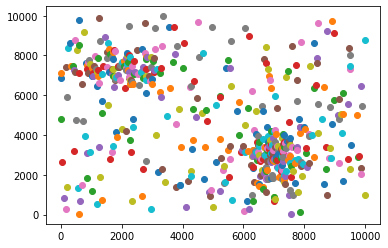

In [4]:
plot_2d(ue) # plot user locations

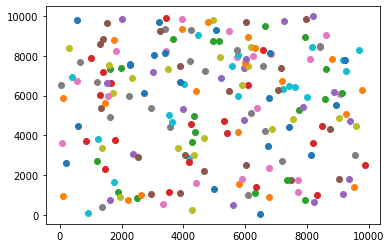

In [5]:
plot_2d(S) # plot possible BS locations

## BS placement optimisation algorithm

Next, we will implement the Metropolis-Hastings Simulated Annealing optimisation algorithm to solve the most optimal BS placement in the generated dataset. Let's start by defining the constants outlined in the instructions:

In [7]:
# Constants

B_max = 30 # Number of deployed BSs
R_ue = 1 # Individual UE revenue
C_bs = 5 # BS operational cost

In [12]:
SA = Anneal(ue, S, B_max, R_ue, C_bs)
#sa = Anneal(0, np.array((2,2)), np.array((2,2)), 0, 0, 0)

print(SA.user_coords)
SA.users_within_radius(S[0,0], S[0,1])


[[2525 7268    0]
 [2471 7339    0]
 [1116 7438    0]
 ...
 [ 293  508    0]
 [4590 7487    0]
 [6766 2586    0]]
(3,)
(3,)
[-1855040   112005 -2229048]
